In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from imvc.datasets import LoadDataset
from imvc.impute import MOFAImputer
from imvc.preprocessing import MultiViewTransformer
from imvc.ampute import Amputer
import seaborn as sns

In [3]:
Xs = LoadDataset.load_dataset(dataset_name="buaa")
p = 0.3
amputed_Xs = Amputer(p= p, mechanism="MCAR", random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(42).choice([True, False], p= [1-p,p], size = X.shape)] = np.nan

In [4]:
n_components_list = [1, 2, 4, 8, 16]
errs = []
for n_components in n_components_list:
    pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                             MOFAImputer(n_components = n_components, random_state=42).set_output(transform="pandas"))
    transformed_Xs = pipeline.fit_transform(amputed_Xs)
    
    
    err = np.mean([mean_squared_error(X, transformed_X) for X,transformed_X in zip(Xs, transformed_Xs)])
    errs.append(err)

In [5]:
pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                         MultiViewTransformer(SimpleImputer().set_output(transform= "pandas")))
transformed_Xs = pipeline.fit_transform(amputed_Xs)
baseline = np.mean([mean_squared_error(X, transformed_X) for X,transformed_X in zip(Xs, transformed_Xs)])

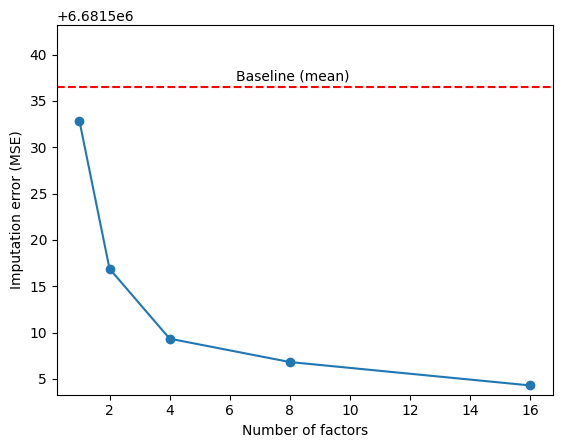

In [17]:
ax = pd.Series(errs, index= n_components_list).plot(style= "-o", ylim= (min(errs) -1, baseline*1.000001), ylabel= "Imputation error (MSE)", xlabel= "Number of factors", rot= 0)
ax.text(np.mean(n_components_list), baseline*1.0000001, "Baseline (mean)")
_ = ax.axhline(baseline, linestyle= "--", color= "red")

In [186]:
p = 0.2
amputed_Xs = Amputer(p= p, mechanism="MCAR", random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]

In [187]:
n_components_list = [1, 2, 4, 8, 16, 32]
metrics = []
for n_components in n_components_list:
        pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                                 MOFAImputer(n_components = n_components, random_state=42).set_output(transform="pandas"))
        imputed_Xs = pipeline.fit_transform(amputed_Xs)
        transformed_Xs = pipeline[0].transform(Xs)
        metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
        metrics.append(metric)

In [189]:
pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                         MultiViewTransformer(SimpleImputer().set_output(transform= "pandas")))
imputed_Xs = pipeline.fit_transform(amputed_Xs)
transformed_Xs = pipeline[0].transform(Xs)
baseline = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])

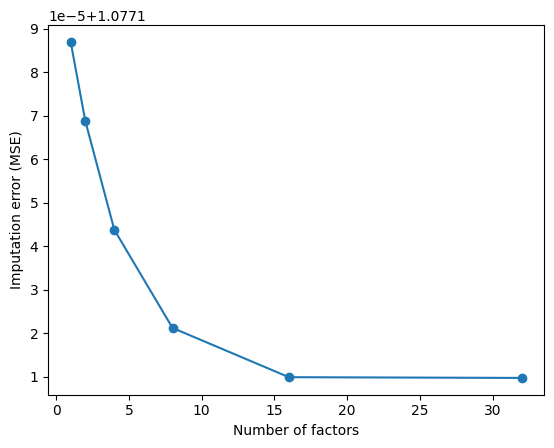

In [197]:
ax = pd.Series(metrics, index= n_components_list).plot(style= "-o", ylabel= "Imputation error (MSE)", xlabel= "Number of factors", rot= 0)

In [191]:
baseline

1.2044750731989056

In [175]:
Xs = LoadDataset.load_dataset(dataset_name="sensIT300")
ps = np.arange(0.2 	% Incomplete samples, 1., 0.2)
n_times = 25
n_components = 4
all_metrics = {}

In [176]:
key = "MOFA"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for i in range(n_times):
        amputed_Xs = Amputer(p= p, mechanism="MCAR", random_state=42).fit_transform(Xs)
        for X in amputed_Xs:
            X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
        masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
        pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                                 MOFAImputer(n_components = n_components, random_state=42).set_output(transform="pandas"))
        imputed_Xs = pipeline.fit_transform(amputed_Xs)
        transformed_Xs = pipeline[0].transform(Xs)
        metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
        all_metrics[key][missing_percentage][i] = metric

In [177]:
key = "Baseline (mean)"
all_metrics[key] = {}
for p in ps:
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for i in range(n_times):
        amputed_Xs = Amputer(p= p, mechanism="MCAR", random_state=42).fit_transform(Xs)
        for X in amputed_Xs:
            X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
        masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
        pipeline = make_pipeline(MultiViewTransformer(StandardScaler().set_output(transform="pandas")),
                                 MultiViewTransformer(SimpleImputer().set_output(transform="pandas")))
        imputed_Xs = pipeline.fit_transform(amputed_Xs)
        transformed_Xs = pipeline[0].transform(Xs)
        metric = np.mean([mean_squared_error(transformed_X.values[mask], imputed_X.values[mask]) for transformed_X,imputed_X,mask in zip(transformed_Xs, imputed_Xs, masks)])
        all_metrics[key][missing_percentage][i] = metric

In [178]:
flattened_data = [
    {
        'Method': outer_key,
        '% Incomplete samples': inner_key,
        **inner_dict
    }
    for outer_key, inner_dicts in all_metrics.items()
    for inner_key, inner_dict in inner_dicts.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', '% Incomplete samples'], var_name='Iteration', value_name='Imputation error (MSE)')
df = df.sort_values(["% Incomplete samples", "Method", "Iteration"], ascending=[True, False, True])

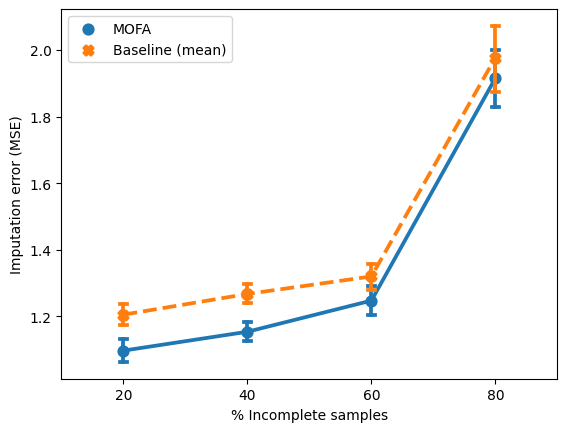

In [183]:
ax = sns.pointplot(data=df, x="% Incomplete samples", y="Imputation error (MSE)", hue="Method", markers=["o", "X"], linestyles=["-", "--"], seed= 42, capsize= 0.05)
ax = ax.get_legend().set_title(None)